In [1]:
import numpy as np
from scipy.linalg import solve

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

#models
import shiftNMF_frozen as Hybrid
import shiftNMFDiscTau as DiscTau
import torchNMF as standard

from helpers.generators import *

from tqdm import tqdm

In [2]:
#Create data
# Define random sources, mixings and shifts; H, W and tau
N, M, d = 7, 10000, 3
Fs = 1000  # The sampling frequency we use for the simulation
t0 = 10    # The half-time interval we look at
t = np.arange(-t0, t0, 1/Fs)  # the time samples
f = np.arange(-Fs/2, Fs/2, Fs/len(t))  # the corresponding frequency samples

def shift_dataset(W, H, tau):
    # Get half the frequencies
    Nf = H.shape[1] // 2 + 1
    # Fourier transform of S along the second dimension
    Hf = np.fft.fft(H, axis=1)
    # Keep only the first Nf[1] elements of the Fourier transform of S
    Hf = Hf[:, :Nf]
    # Construct the shifted Fourier transform of S
    Hf_reverse = np.fliplr(Hf[:, 1:Nf - 1])
    # Concatenate the original columns with the reversed columns along the second dimension
    Hft = np.concatenate((Hf, np.conj(Hf_reverse)), axis=1)
    f = np.arange(0, M) / M
    omega = np.exp(-1j * 2 * np.pi * np.einsum('Nd,M->NdM', tau, f))
    Wf = np.einsum('Nd,NdM->NdM', W, omega)
    # Broadcast Wf and H together
    Vf = np.einsum('NdM,dM->NM', Wf, Hft)
    V = np.fft.ifft(Vf)
    return V.real

np.random.seed(42)

# Random mixings:
W = np.random.dirichlet(np.ones(d), N)
W = np.append(W, [[1,0,0]], axis=0)
W = np.append(W, [[0,1,0]], axis=0)
W = np.append(W, [[0,0,1]], axis=0)
N = N+3

#W = np.random.rand(N, d)
shift = 500
# Random gaussian shifts
tau = np.random.randint(-shift, shift, size=(N, d))
tau[W==0] = 0
#set tau to 0 where W is 0

# tau = np.zeros((N,d))
#tau = np.random.randint(0, 1000, size=(N, d))
# Purely positive underlying signals. I define them as 3 gaussian peaks with random mean and std.
mean = [2000, 5000, 8000]
std = [70, 240, 30]
t = np.arange(0, 10000, 1)

H = np.array([multiplet(t, 1, m, s, 100) for m, s in list(zip(mean, std))])
# H_lorentz = np.array([m(m, s, t) for m, s in list(zip(mean, std))])
H_duplet = np.array([multiplet(t, 2, m, s, 1000) for m, s in list(zip(mean, std))])

X = shift_dataset(W, H, tau)
# X_lorentz = shift_dataset(W, H_lorentz, tau)
X_duplet = shift_dataset(W, H_duplet, tau)

In [3]:
def NLARS(XtX, Xty, inc_path=False, maxK=np.inf):
    """
    Usage:
        beta, path, lambda = NLARS(XtX, Xty, inc_path, maxK)
    
        solves the problem argmin_beta 1/2||y-X*beta||_2^2 s.t. beta>=0
        The problem is solved using a modification of the Least Angle Regression and Selection
        algorithm. As such the entire regularization path for the LASSO problem
        min 1/2||y-X*beta||_2^2 + lambda|beta|_1    s.t. beta>=0
        for all values of lambda is given in path.
    
        Please make reference to the following article describing the algorithm:
    
            Mørup, M and Madsen, K.H. and Hansen, L.K. "Approximate L0
            constrained Non-negative Matrix and Tensor Factorization"   IEEE International Symposium on Circuits and Systems, ISCAS 2008.
            pp. 1328 - 1331, 2008
    
    Input:
        XtX         matrix of size D x D           
        Xty         vector of size D x 1
        inc_path    include the path in the output (default: False)
        maxK        maximal number of active elements in beta (default: inf)
    Output:
        beta    D x 1 solution vector 
        path    the entire solution path
        lambda  regularization value at beginning of step corresponds to
                value of negative gradient
    """

    p = len(Xty)
    k = 0
    if inc_path:
        path = np.zeros((p, 4 * p))
        lambda_ = np.zeros(4 * p)
    else:
        path = None
        lambda_ = None

    # Initialization
    I = list(range(p))  # inactive set
    A = []  # active set
    beta = np.zeros_like(Xty)

    XtXbeta = XtX @ beta
    c = (Xty - XtXbeta)
    C = np.max(c[I])
    j = np.argmax(c[I])
    A.append(I[j])
    I.pop(j)

    # Insert initial zero solution in path.
    k += 1
    if inc_path:
        path[:, k - 1] = beta
        lambda_[k - 1] = C if C.size > 0 else 0

    # NLARS main loop
    while np.sum(c[A]) / len(A) >= 1e-9 and np.count_nonzero(beta) < maxK:
        s = np.ones(len(A))
        w = solve(XtX[np.ix_(A, A)], s)
        XtXw = XtX[:, A] @ w
        
        # Gradient in inactive set of same value as of active set
        gamma1 = (C - c[I]) / (XtXw[A[0]] - XtXw[I])
        
        # Check step length towards zero for active elements
        gamma2 = -beta[A] / w
        
        # Check step to zero gradient for active elements
        gamma3 = np.array([c[A[0]] / XtXw[A[0]]])
        
        # Concatenate the three step types
        # gamma = np.concatenate([gamma1, gamma2, gamma3])
        # concatenate the three step types, they have different shapes so they need to be concatenated differently
        gamma = np.zeros(len(gamma1) + len(gamma2) + len(gamma3))
        gamma[:len(gamma1)] = gamma1
        gamma[len(gamma1):len(gamma1) + len(gamma2)] = gamma2
        gamma[len(gamma1) + len(gamma2):] = gamma3
        
        # Make negative and machine impression steps irrelevant
        gamma[gamma <= 1e-9] = np.inf
        
        # Find smallest step
        mu = np.min(gamma)
        t = np.argmin(gamma)
        
        # Update beta                       
        beta[A] = beta[A] + mu * w

        # Check whether an active element has reached zero
        if len(gamma1) <= t < len(gamma1) + len(gamma2):
            lassocond = 1
            j = t - len(gamma1)
            I.append(A[j])
            A.pop(j)
        else:
            lassocond = 0
        
        # Recalculate gradient
        # print('recalc')
        XtXbeta = XtX @ beta
        c = (Xty - XtXbeta)
        
        if len(I) == 0:
            break
        
        C = np.max(c[I])
        j = np.argmax(c[I])
        
        # Update path
        k += 1
        if inc_path:
            path[:, k - 1] = beta
            lambda_[k - 1] = C if C.size > 0 else 0
        
        if not lassocond:
            A.append(I[j])
            I.pop(j)
    
    # Trim path
    if inc_path:
        path = path[:, :k]
        lambda_ = lambda_[:k]

    return beta, path, lambda_

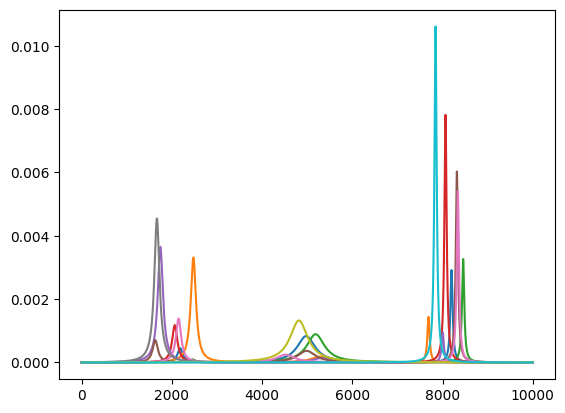

In [4]:
plt.plot(X.T)
plt.show()

In [5]:
hybrid = Hybrid.ShiftNMF(X, 10, lr=0.1, alpha=1e-6, patience=1000, min_imp=0)
W_hyb,H_hyb,tau_hyb, running_loss_hybrid = hybrid.fit(verbose=True, return_loss=True, max_iter=250, tau_iter=0, Lambda=0)

centering4, Loss: 0.007465027369576597, Tau: 4280.232470322144
epoch: 250, Loss: 0.005398602765432802, Tau: 4654.75767360665155


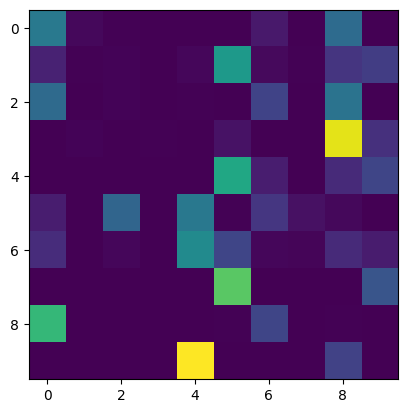

In [6]:
plt.imshow(W_hyb)
plt.show()

In [7]:
def calc_scoring(X, H, inc_path=False, maxK=np.inf):
    paths, lambdas = [], []
    W = np.zeros((X.shape[0], H.shape[0]))
    #print(W.shape)
    for i in range(X.shape[0]):
        # print(i)
        XtX = H @ H.T
        Xty = H @ X[i,:].T
        # Xty = Xty.reshape(len(Xty))
        
        # print(XtX, Xty)
        
        W[i,:], path, lambda_ = NLARS(XtX, Xty, inc_path=inc_path, maxK=maxK)
        paths.append(path)
        lambdas.append(lambda_)
    
    return W, paths, lambdas
    # XtX = H.T @ H
    # Xty = H.T @ X
    # print(XtX.shape, Xty.shape)
    # beta, path, _ = NLARS(XtX, Xty)
    # return beta

W_nlar, paths, lambdas = calc_scoring(X, H_hyb, inc_path=True, maxK=3)

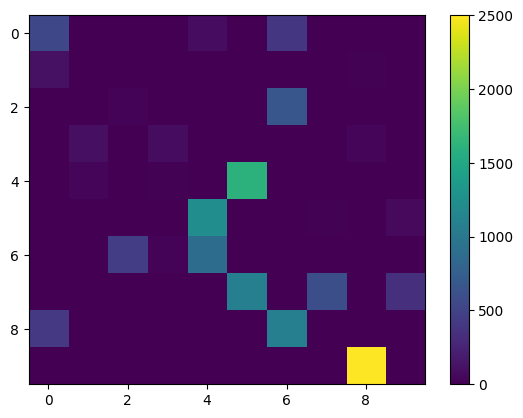

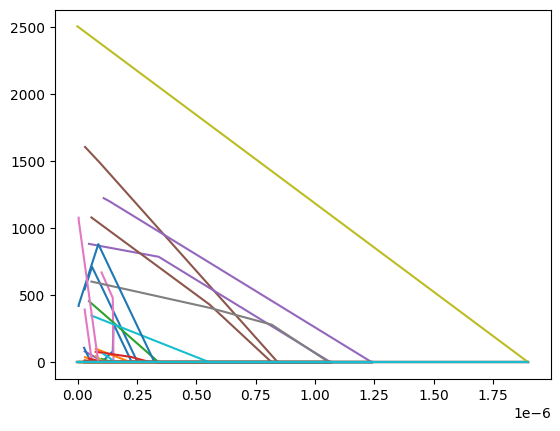

In [8]:
#plot path over lambda
plt.imshow(W_nlar, aspect='auto')
plt.colorbar()
plt.show()

for i in range(len(paths)):
    plt.plot(lambdas[i], paths[i].T)
plt.show()

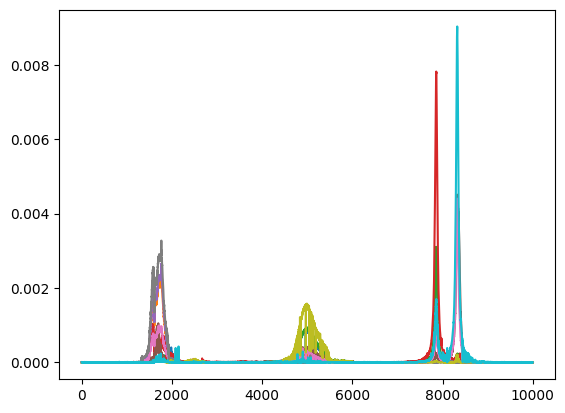

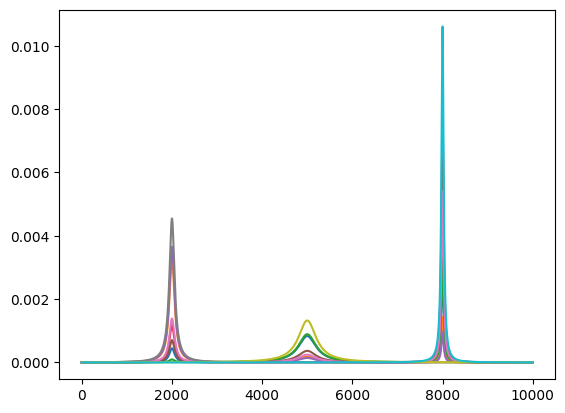

In [9]:
#reconstruct with W_nlar
X_nlar = W_hyb @ H_hyb
plt.plot(X_nlar.T)
plt.show()
plt.plot((W@H).T)
plt.show()